<a href="https://colab.research.google.com/github/aruntakhur/DeepLearning_Aut_2020_IIITDWD/blob/master/MultiLayerPercepron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [2]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(y_train.shape)
print(y_test.shape)
print(x_test.shape)

(60000, 784)
(60000,)
(10000,)
(10000, 784)


In [3]:
import numpy as np

train_filter = np.where((y_train == 0 ) | (y_train == 4))
test_filter = np.where((y_test == 0) | (y_test == 4))

In [4]:
X_train, Y_train = x_train[train_filter], y_train[train_filter]
X_test, Y_test = x_test[test_filter], y_test[test_filter]
Y_train = [1 if x==4 else x for x in Y_train] 
Y_train = np.array(Y_train).reshape(1,-1)
Y_test = [1 if x==4 else x for x in Y_test] 
Y_test = np.array(Y_test).reshape(1,-1)

In [5]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(11765, 784)
(1, 11765)
(1962, 784)
(1, 1962)


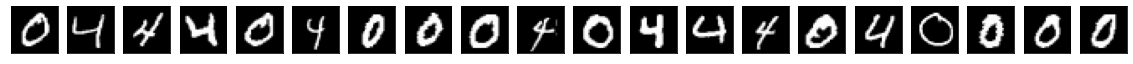

In [6]:
import matplotlib.pyplot as plt

n = 20  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


In [7]:
print(len(Y_train[np.where(Y_train==0)]))
print(Y_train[0,15])

5923
1


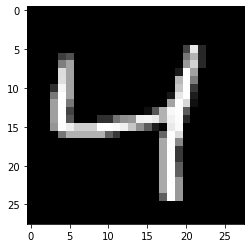

In [8]:
XX_train = X_train.astype('float32') / 255.
XX_test = X_test.astype('float32') / 255.
plt.imshow(XX_train[1].reshape(28,28))

In [9]:
XX_train = XX_train.T
XX_test = XX_test.T
Y_train = Y_train.reshape(1,-1)
Y_test = Y_test.reshape(1,-1)

In [10]:
print(XX_test.shape)

(784, 1962)


In [11]:
def sigmoid(Z):      
    A = 1/(1+np.exp(-Z))       
    return A

In [12]:
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 
    return A

In [13]:
def deep_initialize_parameters(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])/ np.sqrt(layer_dims[l-1])# *0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

In [14]:
def linear_activation_forward(A_prev, W, b, activation):
    Z = np.dot(W,A_prev) + b
    linear_cache = (A_prev, W, b)
        
    if activation == "sigmoid":    
        A = sigmoid(Z)
    elif activation == "relu":
        A = relu(Z)
    
    cache = (linear_cache, Z)
    return A, cache    

In [15]:
def deep_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2  
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    return AL, caches

In [16]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    return cost

In [17]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

In [18]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

In [19]:
def sigmoid_backward(dA, cache):
    Z = cache    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)    
    return dZ

In [20]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [21]:
def deep_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads  

In [22]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [23]:
def deep_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000): #lr was 0.009
    costs = []
    parameters = deep_initialize_parameters(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = deep_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = deep_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        costs.append(cost)
        if i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
    return parameters, costs

In [24]:
layers_dims = [XX_train.shape[0],100, 50, 1]
par, costs = deep_layer_model(XX_train, Y_train, layers_dims, learning_rate=0.0075, num_iterations=1000)

Cost after iteration 0: 0.695144
Cost after iteration 100: 0.387455
Cost after iteration 200: 0.165642
Cost after iteration 300: 0.087401
Cost after iteration 400: 0.058353
Cost after iteration 500: 0.044612
Cost after iteration 600: 0.036903
Cost after iteration 700: 0.032055
Cost after iteration 800: 0.028757
Cost after iteration 900: 0.026379


In [25]:
def predict(X,Y,parameters):
       m = X.shape[1]
       p = np.zeros((1, m),dtype=int)
       probs, caches = deep_model_forward(X, parameters) 
       for i in range(0, probs.shape[1]):
        if probs[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
       print("Accuracy: %s" % str(np.sum(p == Y)/float(m)))
       print(np.sum(p == Y))
       #return p

Accuracy: 0.9948151296217594
11704


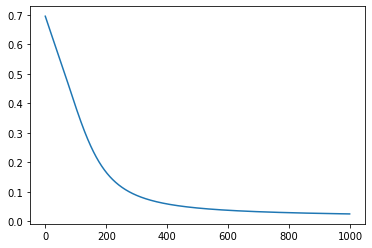

In [26]:
predict(XX_train,Y_train,par)
plt.plot(range(len(costs)),costs)

In [28]:
predict(XX_test,Y_test,par)

Accuracy: 0.9979612640163099
1958
